# Introducing the Keras Sequential API on Vertex AI Platform

**Learning objectives**
  1. Build a DNN model using the Keras Sequential API
  1. Learn how to use feature columns in a Keras model
  1. Learn how to train a model with Keras
  1. Learn how to save/load, and deploy a Keras model on GCP
  1. Learn how to deploy the Model to Vertex AI and make predictions with the Keras model

## Introduction

The Keras sequential API allows you to create Tensorflow models layer-by-layer. This is useful for building most kinds of machine learning models

In this lab, we'll see how to build a simple deep neural network model using the Keras sequential api and feature columns. Once we have trained our model, we will deploy it using Vertex AI and see how to call our model for online prediciton.



In [2]:
!pip3 install google-cloud-bigquery==2.34.4 --user

In [3]:
!pip install google-cloud-aiplatform==1.20.0 --user

  Using cached google_cloud_aiplatform-1.20.0-py2.py3-none-any.whl (2.3 MB)
  Attempting uninstall: google-cloud-aiplatform
    Found existing installation: google-cloud-aiplatform 0.7.1
    Uninstalling google-cloud-aiplatform-0.7.1:
      Successfully uninstalled google-cloud-aiplatform-0.7.1
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


**Note:** Please restart the kernel by clicking **Kernel > Restart Kernel**

Start by importing the necessary libraries for this lab.

In [4]:
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from google.cloud import aiplatform
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.models import Sequential

print(tf.__version__)
%matplotlib inline

2023-10-16 03:05:57.389848: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 03:05:58.818255: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-16 03:05:58.818389: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

2.11.0


## Load raw data

We will use the taxifare dataset, using the CSV files that we created in the first notebook of this sequence. Those files have been saved into `../data`.

In [5]:
!ls -l ../data/*.csv

-rw-r--r-- 1 jupyter jupyter  123590 Oct 15 11:55 ../data/taxi-test.csv
-rw-r--r-- 1 jupyter jupyter 2186310 Oct 15 11:55 ../data/taxi-traffic-test.csv
-rw-r--r-- 1 jupyter jupyter 9713118 Oct 15 11:55 ../data/taxi-traffic-train.csv
-rw-r--r-- 1 jupyter jupyter 2036826 Oct 15 11:55 ../data/taxi-traffic-valid.csv
-rw-r--r-- 1 jupyter jupyter  579055 Oct 15 11:55 ../data/taxi-train.csv
-rw-r--r-- 1 jupyter jupyter  123114 Oct 15 11:55 ../data/taxi-valid.csv


In [6]:
!head ../data/taxi*.csv

==> ../data/taxi-test.csv <==
6.0,2013-03-27 03:35:00 UTC,-73.977672,40.784052,-73.965332,40.801025,2,0
19.3,2012-05-10 18:43:16 UTC,-73.954366,40.778924,-74.004094,40.723104,1,1
7.5,2014-05-20 23:09:00 UTC,-73.999165,40.738377,-74.003473,40.723862,2,2
12.5,2015-02-23 19:51:31 UTC,-73.9652099609375,40.76948165893555,-73.98949432373047,40.739742279052734,1,3
10.9,2011-03-19 03:32:00 UTC,-73.99259,40.742957,-73.989908,40.711053,1,4
7.0,2012-09-18 12:51:11 UTC,-73.971195,40.751566,-73.975922,40.756361,1,5
19.0,2014-05-20 23:09:00 UTC,-73.998392,40.74517,-73.939845,40.74908,1,6
8.9,2012-07-18 08:46:08 UTC,-73.997638,40.756541,-73.973303,40.762019,1,7
4.5,2010-07-11 20:39:08 UTC,-73.976738,40.751321,-73.986671,40.74883,1,8
7.0,2013-12-12 02:16:40 UTC,-73.985024,40.767537,-73.981273,40.779302,1,9

==> ../data/taxi-traffic-test.csv <==
15.7,6,12,-73.990072,40.758199,-73.974686,40.742004,2089
6.1,7,2,-73.95647,40.771226,-73.971845,40.750089,1738
4.1,6,18,-73.987871,40.759855,-73.996375,40.7637

## Use tf.data to read the CSV files

In [12]:
CSV_COLUMNS = [
    "fare_amount",
    "pickup_datetime",
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
    "key",
]
LABEL_COLUMN = "fare_amount"
DEFAULTS = [[0.0], ["na"], [0.0], [0.0], [0.0], [0.0], [0.0], ["na"]]
UNWANTED_COLS = ["pickup_datetime", "key"]


def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data

    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


def create_dataset(pattern, batch_size=1, mode="eval"):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS
    )

    dataset = dataset.map(features_and_labels)

    if mode == "train":
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

## Build a simple keras DNN model

We will use feature columns to connect our raw data to our keras DNN model. Feature columns make it easy to perform common types of feature engineering on your raw data. For example, you can one-hot encode categorical data, create feature crosses, embeddings and more.

In [13]:
INPUT_COLS = [
    "pickup_longitude",
    "pickup_latitude",
    "dropoff_longitude",
    "dropoff_latitude",
    "passenger_count",
]

# Create input layer of feature columns

#1
feature_columns = {
    colname: tf.feature_column.numeric_column(colname) for colname in INPUT_COLS
}

Next, we create the DNN model. The Sequential model is a linear stack of layers and when building a model using the Sequential API, you configure each layer of the model in turn. Once all the layers have been added, you compile the model. 

In [14]:
# Build a keras DNN model using Sequential API

#2a
model = Sequential(
    [
        DenseFeatures(feature_columns=feature_columns.values()),
        Dense(units=32, activation="relu", name="h1"),
        Dense(units=8, activation="relu", name="h2"),
        Dense(units=1, activation="linear", name="output"),
    ]
)

2023-10-16 03:10:21.692325: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-10-16 03:10:21.692392: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-16 03:10:21.692430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (7a568c662824): /proc/driver/nvidia/version does not exist
2023-10-16 03:10:21.692829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

Next, to prepare the model for training, you must configure the learning process. This is done using the compile method. The compile method takes three arguments:

* An optimizer. This could be the string identifier of an existing optimizer (such as `rmsprop` or `adagrad`)
* A loss function. This is the objective that the model will try to minimize.
* A list of metrics. For any machine learning problem you will want a set of metrics to evaluate your model.

In [16]:
#2b
# Create a custom evalution metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


# Compile the keras model
model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

## Train the model

To train your model, Keras provides three functions that can be used:
 1. `.fit()` for training a model for a fixed number of epochs (iterations on a dataset).
 2. `.fit_generator()` for training a model on data yielded batch-by-batch by a generator
 3. `.train_on_batch()` runs a single gradient update on a single batch of data. 
 
The `.fit()` function works well for small datasets which can fit entirely in memory. However, for large datasets (or if you need to manipulate the training data on the fly via data augmentation, etc) you will need to use `.fit_generator()` instead. The `.train_on_batch()` method is for more fine-grained control over training and accepts only a single batch of data.

The taxifare dataset we sampled is small enough to fit in memory, so can we could use `.fit` to train our model. Our `create_dataset` function above generates batches of training examples, so we could also use `.fit_generator`. In fact, when calling `.fit` the method inspects the data, and if it's a generator (as our dataset is) it will invoke automatically `.fit_generator` for training. 

We start by setting up some parameters for our training job and create the data generators for the training and validation data.

In [17]:
TRAIN_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern="../data/taxi-train*", batch_size=TRAIN_BATCH_SIZE, mode="train"
)

evalds = create_dataset(
    pattern="../data/taxi-valid*", batch_size=1000, mode="eval"
).take(NUM_EVAL_EXAMPLES // 1000)

There are various arguments you can set when calling the [.fit method](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#fit). Here `x` specifies the input data which in our case is a `tf.data` dataset returning a tuple of (inputs, targets). The `steps_per_epoch` parameter is used to mark the end of training for a single epoch. Here we are training for NUM_EVALS epochs. Lastly, for the `callback` argument we specify a Tensorboard callback so we can inspect Tensorboard after training. 

In [18]:
#3
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

LOGDIR = "./taxi_trained"
history = model.fit(
    x=trainds,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EVALS,
    validation_data=evalds,
    callbacks=[TensorBoard(LOGDIR)],
)

Epoch 1/50


2023-10-16 03:19:25.342427: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 520 of 1000


1/1 [==============================] - ETA: 0s - loss: 846.8641 - rmse: 29.1009 - mse: 846.8641WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs=OrderedDict([('pickup_longitude', <tf.Tensor 'IteratorGetNext:4' shape=(1000,) dtype=float32>), ('pickup_latitude', <tf.Tensor 'IteratorGetNext:3' shape=(1000,) dtype=float32>), ('dropoff_longitude', <tf.Tensor 'IteratorGetNext:1' shape=(1000,) dtype=float32>), ('dropoff_latitude', <tf.Tensor 'IteratorGetNext:0' shape=(1000,) dtype=float32>), ('passenger_count', <tf.Tensor 'IteratorGetNext:2' shape=(1000,) dtype=float32>)]). Consider rewriting this model with the Functional API.


2023-10-16 03:19:34.967840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.


1/1 [==============================] - 22s 22s/step - loss: 846.8641 - rmse: 29.1009 - mse: 846.8641 - val_loss: 727.4520 - val_rmse: 26.9711 - val_mse: 727.4520
Epoch 2/50
1/1 [==============================] - 0s 349ms/step - loss: 729.8451 - rmse: 27.0156 - mse: 729.8451 - val_loss: 632.9343 - val_rmse: 25.1579 - val_mse: 632.9343
Epoch 3/50
1/1 [==============================] - 0s 285ms/step - loss: 640.3182 - rmse: 25.3045 - mse: 640.3182 - val_loss: 566.0288 - val_rmse: 23.7904 - val_mse: 566.0288
Epoch 4/50
1/1 [==============================] - 0s 287ms/step - loss: 578.4154 - rmse: 24.0503 - mse: 578.4154 - val_loss: 513.5182 - val_rmse: 22.6605 - val_mse: 513.5182
Epoch 5/50
1/1 [==============================] - 0s 416ms/step - loss: 518.8553 - rmse: 22.7784 - mse: 518.8553 - val_loss: 464.5432 - val_rmse: 21.5522 - val_mse: 464.5432
Epoch 6/50
1/1 [==============================] - 0s 355ms/step - loss: 457.4984 - rmse: 21.3892 - mse: 457.4984 - val_loss: 416.4937 - val_rm

### High-level model evaluation

Once we've run data through the model, we can call `.summary()` on the model to get a high-level summary of our network. We can also plot the training and evaluation curves for the metrics we computed above. 

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features (DenseFeatur  multiple                 0         
 es)                                                             
                                                                 
 h1 (Dense)                  multiple                  192       
                                                                 
 h2 (Dense)                  multiple                  264       
                                                                 
 output (Dense)              multiple                  9         
                                                                 
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


Running `.fit` (or `.fit_generator`) returns a History object which collects all the events recorded during training. We can plot the training and validation curves for the model loss and rmse by accessing these elements of the History object.

<Axes: >

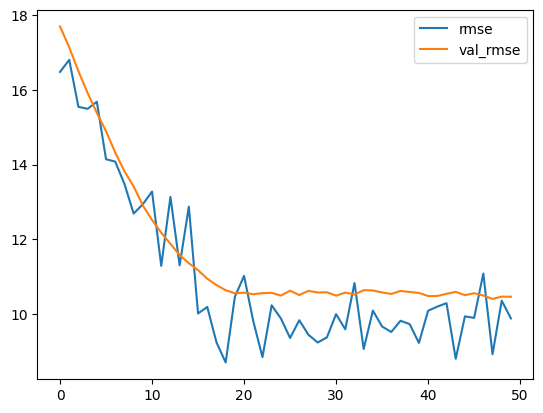

In [25]:
RMSE_COLS = ["rmse", "val_rmse"]

pd.DataFrame(history.history)[RMSE_COLS].plot()

<Axes: >

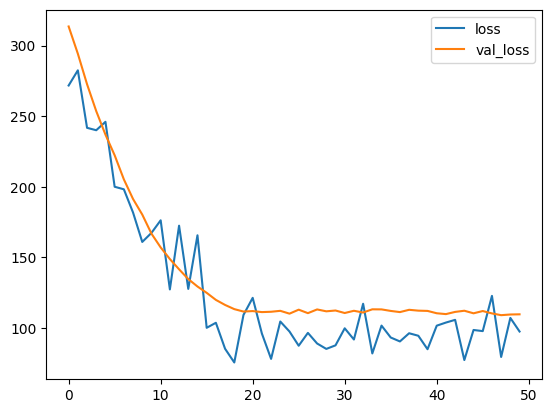

In [26]:
LOSS_COLS = ["loss", "val_loss"]

pd.DataFrame(history.history)[LOSS_COLS].plot()

# Making predictions with our model

To make predictions with our trained model, we can call the [predict method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict), passing to it a dictionary of values. The `steps` parameter determines the total number of steps before declaring the prediction round finished. Here since we have just one example, we set `steps=1` (setting `steps=None` would also work). Note, however, that if x is a `tf.data` dataset or a dataset iterator, and steps is set to None, predict will run until the input dataset is exhausted.

In [27]:
model.predict(
    x={
        "pickup_longitude": tf.convert_to_tensor([-73.982683]),
        "pickup_latitude": tf.convert_to_tensor([40.742104]),
        "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
        "dropoff_latitude": tf.convert_to_tensor([40.755174]),
        "passenger_count": tf.convert_to_tensor([3.0]),
    },
    steps=1,
)

1/1 [==============================] - 0s 40ms/step


array([[11.603747]], dtype=float32)

# Export and deploy our model

Of course, making individual predictions is not realistic, because we can't expect client code to have a model object in memory. For others to use our trained model, we'll have to export our model to a file, and expect client code to instantiate the model from that exported file. 

We'll export the model to a TensorFlow SavedModel format. Once we have a model in this format, we have lots of ways to "serve" the model, from a web application, from JavaScript, from mobile applications, etc.

In [19]:
OUTPUT_DIR = "./export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

EXPORT_PATH = os.path.join(OUTPUT_DIR, TIMESTAMP)

tf.saved_model.save(model, EXPORT_PATH)  # with default serving function

INFO:tensorflow:Assets written to: ./export/savedmodel/20231016032310/assets


INFO:tensorflow:Assets written to: ./export/savedmodel/20231016032310/assets


## Deploy our model to Vertex AI

Finally, we will deploy our trained model to Vertex AI and see how we can make online predicitons. 

In [21]:
PROJECT = !gcloud config list --format 'value(core.project)' 2>/dev/null


In [22]:
print(PROJECT)

['learned-pottery-399802']


In [23]:
PROJECT = PROJECT[0]
BUCKET = PROJECT
REGION = "us-central1"
MODEL_DISPLAYNAME = f"taxifare-kerase-sequential{TIMESTAMP}"

print(f"MODEL_DISPLAYNAME: {MODEL_DISPLAYNAME}")

# from https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
SERVING_CONTAINER_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-3:latest"
)

os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION

MODEL_DISPLAYNAME: taxifare-kerase-sequential20231016032310


In [24]:
%%bash
# Create GCS bucket if it doesn't exist already...
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
    echo -e "Bucket exists, let's not recreate it."
else
    echo "Creating a new GCS bucket."
    gsutil mb -l ${REGION} gs://${BUCKET}
    echo "Here are your current buckets:"
    gsutil ls
fi

Bucket exists, let's not recreate it.


In [25]:
!gsutil cp -R $EXPORT_PATH gs://$BUCKET/$MODEL_DISPLAYNAME

Copying file://./export/savedmodel/20231016032310/fingerprint.pb [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20231016032310/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20231016032310/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://./export/savedmodel/20231016032310/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
/ [4 files][183.9 KiB/183.9 KiB]                                                
Operation completed over 4 objects/183.9 KiB.                                    


In [26]:
uploaded_model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAYNAME,
    artifact_uri=f"gs://{BUCKET}/{MODEL_DISPLAYNAME}",
    serving_container_image_uri=SERVING_CONTAINER_IMAGE_URI,
)

Creating Model


INFO:google.cloud.aiplatform.models:Creating Model


Create Model backing LRO: projects/239661236943/locations/us-central1/models/4616987863496523776/operations/5556650772839530496


INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/239661236943/locations/us-central1/models/4616987863496523776/operations/5556650772839530496


Model created. Resource name: projects/239661236943/locations/us-central1/models/4616987863496523776@1


INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/239661236943/locations/us-central1/models/4616987863496523776@1


To use this Model in another session:


INFO:google.cloud.aiplatform.models:To use this Model in another session:


model = aiplatform.Model('projects/239661236943/locations/us-central1/models/4616987863496523776@1')


INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/239661236943/locations/us-central1/models/4616987863496523776@1')


In [34]:
MACHINE_TYPE = "e2-standard-2"

endpoint = uploaded_model.deploy(
    machine_type=MACHINE_TYPE,
    accelerator_type=None,
    accelerator_count=None,
)

Creating Endpoint


INFO:google.cloud.aiplatform.models:Creating Endpoint


Create Endpoint backing LRO: projects/239661236943/locations/us-central1/endpoints/1687603014078038016/operations/8613926416754409472


INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/239661236943/locations/us-central1/endpoints/1687603014078038016/operations/8613926416754409472


Endpoint created. Resource name: projects/239661236943/locations/us-central1/endpoints/1687603014078038016


INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/239661236943/locations/us-central1/endpoints/1687603014078038016


To use this Endpoint in another session:


INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:


endpoint = aiplatform.Endpoint('projects/239661236943/locations/us-central1/endpoints/1687603014078038016')


INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/239661236943/locations/us-central1/endpoints/1687603014078038016')


Deploying model to Endpoint : projects/239661236943/locations/us-central1/endpoints/1687603014078038016


INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/239661236943/locations/us-central1/endpoints/1687603014078038016


Deploy Endpoint model backing LRO: projects/239661236943/locations/us-central1/endpoints/1687603014078038016/operations/1119936636809904128


INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/239661236943/locations/us-central1/endpoints/1687603014078038016/operations/1119936636809904128


Endpoint model deployed. Resource name: projects/239661236943/locations/us-central1/endpoints/1687603014078038016


INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/239661236943/locations/us-central1/endpoints/1687603014078038016


In [37]:
instance = {
    "pickup_longitude": -73.982683,
    "pickup_latitude": 40.742104,
    "dropoff_longitude": -73.983766,
    "dropoff_latitude": 40.755174,
    "passenger_count": 3.0,
}

In [38]:
endpoint.predict([instance])

Prediction(predictions=[[11.6037474]], deployed_model_id='4084582343094829056', model_version_id='1', model_resource_name='projects/239661236943/locations/us-central1/models/7969354836120436736', explanations=None)

# Cleanup

When deploying a model to an endpoint for online prediction, the minimum `min-replica-count` is 1, and it is charged per node hour. So let's delete the endpoint to reduce unnecessary charges. Before we can delete the endpoint, we first undeploy all attached models... 

In [39]:
endpoint.undeploy_all()

Undeploying Endpoint model: projects/239661236943/locations/us-central1/endpoints/1687603014078038016


INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/239661236943/locations/us-central1/endpoints/1687603014078038016


Undeploy Endpoint model backing LRO: projects/239661236943/locations/us-central1/endpoints/1687603014078038016/operations/5925277439214223360


INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/239661236943/locations/us-central1/endpoints/1687603014078038016/operations/5925277439214223360


Endpoint model undeployed. Resource name: projects/239661236943/locations/us-central1/endpoints/1687603014078038016


INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/239661236943/locations/us-central1/endpoints/1687603014078038016


resource name: projects/239661236943/locations/us-central1/endpoints/1687603014078038016

...then delete the endpoint.

In [40]:
endpoint.delete()

Deleting Endpoint : projects/239661236943/locations/us-central1/endpoints/1687603014078038016


INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/239661236943/locations/us-central1/endpoints/1687603014078038016


Delete Endpoint  backing LRO: projects/239661236943/locations/us-central1/operations/2230073944956731392


INFO:google.cloud.aiplatform.base:Delete Endpoint  backing LRO: projects/239661236943/locations/us-central1/operations/2230073944956731392


Endpoint deleted. . Resource name: projects/239661236943/locations/us-central1/endpoints/1687603014078038016


INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/239661236943/locations/us-central1/endpoints/1687603014078038016
